# NOAA Weather Data Analysis - JFK Airport (New York)
This notebook focuses on analyzing and forecasting weather patterns using the **NOAA Weather Dataset** collected from **JFK Airport in New York**. The dataset comprises **114,546 hourly observations** of **12 key climatological variables**, including temperature, wind speed, humidity, and pressure. This notebook teaches the user to extract, clean and analyze sample weather data and predict weather trends to help airports schedule better flight times.

The notebook is organized into three main parts:

# Part 1: Data Cleaning
In this section, we prepare the raw data for analysis by:
- Removing unnecessary or redundant columns to retain only relevant numerical features
- Converting data types and cleaning inconsistencies
- Handling missing values with appropriate filling strategies
- Encoding categorical weather features for downstream analysis

# Part 2: Exploratory Data Analysis (EDA)
Here, we perform visual and statistical exploration of the cleaned dataset:

- Load the cleaned data
- Generate insightful visualizations of key variables
- Identify trends, patterns, and seasonal effects in the time-series data

# Part 3: Time Series Forecasting
This section focuses on predicting future temperatures using time-series models:

- Load the cleaned and preprocessed data
- Establish baseline forecasting models
- Train and evaluate advanced statistical forecasting techniques
# Part 1: Data Cleaning

In [3]:
%%capture
%pip install pandas
#Import and configure the required modules.
# Define required imports
import pandas as pd
import numpy as np
import sys
import re
# These set pandas max column and row display in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

### Read the Raw Data
We start by reading in the raw dataset, displaying the first few rows of the dataframe, and taking a look at the columns and column types present.

In [5]:
%%capture
# Using pandas to read the data 
# Since the `DATE` column consists date-time information, we use Pandas parse_dates keyword for easier data processing

raw_data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/fJKLoMKtgpDAl5MkA6rf2A/jfk-weather.csv", parse_dates=['DATE'])
raw_data.head()

In [6]:
raw_data.dtypes

STATION                               object
STATION_NAME                          object
ELEVATION                            float64
LATITUDE                             float64
LONGITUDE                            float64
                                      ...   
MonthlyTotalCoolingDegreeDays         object
MonthlyDeptFromNormalHeatingDD        object
MonthlyDeptFromNormalCoolingDD        object
MonthlyTotalSeasonToDateHeatingDD    float64
MonthlyTotalSeasonToDateCoolingDD    float64
Length: 90, dtype: object

# Clean the Data
As you can see above, there are a lot of fields which are non-numerical - usually these will be fields that contain text or categorical data, e.g. **HOURLYSKYCONDITIONS**.

There are also fields - such as the main temperature field of interest **HOURLYDRYBULBTEMPF** - that we expect to be numerical, but are instead object type. This often indicates that there may be missing (or null) values, or some other unusual readings that we may have to deal with (since otherwise the field would have been fully parsed as a numerical data type).

In addition, some fields relate to hourly observations, while others relate to daily or monthly intervals. For purposes of later exploratory data analysis, we will restrict the dataset to a certain subset of numerical fields that relate to hourly observations.

In this section, we refer to the **NOAA Local Climatological Data Documentation** to describe the fields and meaning of various values.

### Select data columns
First, we select only the subset of data columns of interest and inspect the column types.

In [7]:
# Choose what columns to import from raw data
column_subset = [
    'DATE',
    'HOURLYVISIBILITY',
    'HOURLYDRYBULBTEMPF',
    'HOURLYWETBULBTEMPF',
    'HOURLYDewPointTempF',
    'HOURLYRelativeHumidity',
    'HOURLYWindSpeed',
    'HOURLYWindDirection',
    'HOURLYStationPressure',
    'HOURLYPressureTendency',
    'HOURLYSeaLevelPressure',
    'HOURLYPrecip',
    'HOURLYAltimeterSetting'
]

# Filter dataset to relevant columns
hourly_data = raw_data[column_subset]
# Set date index
hourly_data = hourly_data.set_index(pd.DatetimeIndex(hourly_data['DATE']))
hourly_data.drop(['DATE'], axis=1, inplace=True)
hourly_data.replace(to_replace='*', value=np.nan, inplace=True)
hourly_data.head()

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2010-01-01 00:51:00,6.00,33.0,32.0,31,92.0,0.0,000,29.97,8.0,29.99,0.01,29.99
2010-01-01 01:00:00,5.59,33.0,32.0,31,92.0,0.0,000,29.96,8.0,29.99,NaN,NaN
2010-01-01 01:51:00,6.00,33.0,33.0,32,96.0,0.0,000,29.97,NaN,29.99,0.02,29.99
2010-01-01 02:03:00,6.00,34.0,33.0,32,93.0,0.0,000,29.97,NaN,NaN,T,29.99
2010-01-01 02:28:00,5.00,34.0,33.0,32,93.0,0.0,000,29.97,NaN,NaN,T,29.99


In [8]:
#hourly_data.reset_index(inplace=True)

In [9]:
hourly_data.dtypes

HOURLYVISIBILITY           object
HOURLYDRYBULBTEMPF         object
HOURLYWETBULBTEMPF         object
HOURLYDewPointTempF        object
HOURLYRelativeHumidity     object
HOURLYWindSpeed            object
HOURLYWindDirection        object
HOURLYStationPressure      object
HOURLYPressureTendency    float64
HOURLYSeaLevelPressure     object
HOURLYPrecip               object
HOURLYAltimeterSetting     object
dtype: object

In [10]:
hourly_data['HOURLYPrecip'].unique()

array(['0.01', nan, '0.02', 'T', '0.00', '0.10', '0.07', '0.03', '0.05',
       '0.15', '0.06', '0.08', '0.04', '0.09', '0.11', '0.20', '0.13',
       '0.14', '0.05s', '0.12', '0.24', '0.02s', '0.17', '0.16', '0.47',
       '0.28', '0.32', '0.19', '0.22', '0.18', '0.26', '0.23', '0.30',
       '0.33', '0.04s', '0.36', '0.40', '0.41', '0.51', '0.50', '0.68s',
       '0.21', '0.35', '0.54', '0.01s', '0.34', '0.94', '1.14', '1.18',
       '1.15', '0.65', '0.74', '0.39', '0.67', '0.29', '0.46', '0.87',
       '1.10', '0.52', '0.08s', '0.37', '0.42', '0.03s', '0.09s', '0.11s',
       '0.10s', '0.25', '0.33s', '0.13s', '0.38', '0.64s', '0.06s',
       '0.17s', '0.69s', '0.73', '2.41', '0.57', '0.84', '0.86', '0.27',
       '0.60', '0.45', '0.75', '1.26', '0.59', '0.68', '0.79', '0.70',
       '0.44', '0.43', '0.53', '0.37s', '0.77', '0.85', '0.93', '0.55',
       '0.56', '1.52', '1.05', '1.76', '0.07s', '0.63', '1.19', '0.12s',
       '0.18s', '0.58', '0.48', '0.66', '0.29s', '0.71', '0.20s'

We can see that some values end with an s (indicating snow), while there is a strange value 0.020.01s which appears to be an error of some sort. To deal with T values, we will set the observation to be 0. We will also replace the erroneous value 0.020.01s with NaN.

In [11]:
%%capture
# Fix imported data
hourly_data['HOURLYPrecip'].replace(to_replace='T', value='0.00', inplace=True)
hourly_data['HOURLYPrecip'].replace('0.020.01s', np.nan, inplace=True)

### Convert columns to numerical types
Next, we will convert string columns that refer to numerical values to numerical types. For columns such as HOURLYPrecip, we first also drop the non-numerical parts of the value (the s character).

In [12]:
# Set of columns to convert
messy_columns = column_subset[1:]

# Convert columns to float32 datatype
for i in messy_columns:
    hourly_data[i] = hourly_data[i].apply(lambda x: re.sub('[^0-9,.-]', '', x) if type(x) == str else x).replace('', np.nan).astype(('float32'))

We can now see that all fields have numerical data type.

In [13]:
print(hourly_data.info())
hourly_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114545 entries, 2010-01-01 00:51:00 to 2018-07-27 23:59:00
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   HOURLYVISIBILITY        96464 non-null   float32
 1   HOURLYDRYBULBTEMPF      111403 non-null  float32
 2   HOURLYWETBULBTEMPF      111245 non-null  float32
 3   HOURLYDewPointTempF     111395 non-null  float32
 4   HOURLYRelativeHumidity  111395 non-null  float32
 5   HOURLYWindSpeed         111358 non-null  float32
 6   HOURLYWindDirection     110444 non-null  float32
 7   HOURLYStationPressure   111256 non-null  float32
 8   HOURLYPressureTendency  48038 non-null   float32
 9   HOURLYSeaLevelPressure  99522 non-null   float32
 10  HOURLYPrecip            79762 non-null   float32
 11  HOURLYAltimeterSetting  86878 non-null   float32
dtypes: float32(12)
memory usage: 6.1 MB
None


,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2010-01-01 00:51:00,6.00,33.0,32.0,31.0,92.0,0.0,0.0,29.969999,8.0,29.99,0.01,29.99
2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,0.0,29.959999,8.0,29.99,NaN,NaN
2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,NaN,29.99,0.02,29.99
2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,NaN,NaN,0.00,29.99
2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,NaN,NaN,0.00,29.99


### Reformat and process data¶
Next, we will clean up some of the data columns to ensure their values fall within the parameters defined by the NOAA documentation (referred to above).

In [14]:
# Generate the summary statistics for each column
hourly_data.describe()

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
count,96464.000000,111403.000000,111245.000000,111395.000000,111395.000000,111358.000000,110444.000000,111256.000000,48038.000000,99522.000000,79762.000000,86878.000000
mean,8.758805,55.310612,49.703098,43.309196,67.132141,11.268045,192.511597,29.990639,4.388963,30.026194,0.007032,30.009537
std,2.742651,17.169744,16.062113,19.357059,20.278572,6.175006,107.606514,0.238452,2.741795,0.233693,0.042636,0.239821
min,0.000000,1.000000,-1.000000,-22.000000,8.000000,0.000000,0.000000,28.490000,0.000000,28.540001,0.000000,28.510000
25%,9.940000,42.000000,37.000000,29.000000,51.000000,7.000000,110.000000,29.850000,2.000000,29.879999,0.000000,29.870001
50%,10.000000,56.000000,50.000000,45.000000,69.000000,10.000000,200.000000,29.990000,5.000000,30.020000,0.000000,30.010000
75%,10.000000,70.000000,64.000000,60.000000,85.000000,15.000000,280.000000,30.139999,7.000000,30.170000,0.000000,30.160000
max,99.419998,102.000000,85.000000,84.000000,100.000000,53.000000,360.000000,30.830000,8.000000,30.850000,2.410000,30.850000


According to the documentation, the **HOURLYPressureTendency** field should be an integer value in the **range [0, 8]**. Let's check if this condition holds for this dataset.

In [15]:
# Check if categorical variable HOURLYPressureTendency ever has a non-integer entry outside the bounds of 0-8
cond = len(hourly_data[~hourly_data['HOURLYPressureTendency'].isin(list(range(0,9)) + [np.nan])])
print('Hourly Pressure Tendency should be between 0 and 8: {}'.format(cond == 0))

Hourly Pressure Tendency should be between 0 and 8: True


Hourly Pressure Tendency should be between 0 and 8: True The **HOURLYVISIBILITY** should be an integer in the **range [0, 10]**. Let's check this condition too.

In [16]:
# Hourly Visibility should be between 0 and 10
hourly_data[(hourly_data['HOURLYVISIBILITY'] < 0) | (hourly_data['HOURLYVISIBILITY'] > 10)]

,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
DATE,,,,,,,,,,,,
2011-10-16 11:51:00,14.000000,68.0,53.0,37.0,33.0,16.0,250.0,29.85,NaN,NaN,NaN,29.870001
2015-06-21 17:45:00,99.419998,79.0,72.0,68.0,70.0,37.0,310.0,29.74,NaN,NaN,0.0,29.760000


We find that a couple of observations fall outside the range. These must be spurious data observations and we handle them by replacing them with NaN.

In [17]:
# Replace any hourly visibility figure outside these bounds with nan
hourly_data.loc[hourly_data['HOURLYVISIBILITY'] > 10, 'HOURLYVISIBILITY'] = np.nan

# Hourly Visibility should be between 0 and 10
cond = len(hourly_data[(hourly_data['HOURLYVISIBILITY'] < 0) | (hourly_data['HOURLYVISIBILITY'] > 10)])
print('Hourly Visibility should be between 0 and 10: {}'.format(cond == 0))

Hourly Visibility should be between 0 and 10: True


Finally, we check if there are any duplicates with respect to our DATE index and check furthermore that our dates are in the correct order (that is, strictly increasing).

In [18]:
cond = len(hourly_data[hourly_data.index.duplicated()].sort_index())
print('Date index contains no duplicate entries: {}'.format(cond == 0))

Date index contains no duplicate entries: True


In [19]:
# Make sure time index is sorted and increasing
print('Date index is strictly increasing: {}'.format(hourly_data.index.is_monotonic_increasing))

Date index is strictly increasing: True


In [20]:
hourly_data.reset_index(inplace=True)

In [21]:
hourly_data.columns

Index(['DATE', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPF', 'HOURLYWETBULBTEMPF',
       'HOURLYDewPointTempF', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed',
       'HOURLYWindDirection', 'HOURLYStationPressure',
       'HOURLYPressureTendency', 'HOURLYSeaLevelPressure', 'HOURLYPrecip',
       'HOURLYAltimeterSetting'],
      dtype='object')

We will now also replace missing values. For numerical values, we will linearly interpolate between the previous and next valid obvservations. For the categorical HOURLYPressureTendency field, we will replace missing values with the last valid observation.

In [22]:
%%capture
hourly_data['HOURLYPressureTendency'] = hourly_data['HOURLYPressureTendency'].fillna(method='ffill') # fill with last valid observation
hourly_data = hourly_data.interpolate(method='linear') # interpolate missing values
hourly_data.drop(hourly_data.index[0], inplace=True) # drop first row

In [23]:
print(hourly_data.info())
print()
hourly_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114544 entries, 1 to 114544
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DATE                    114544 non-null  datetime64[ns]
 1   HOURLYVISIBILITY        114544 non-null  float32       
 2   HOURLYDRYBULBTEMPF      114544 non-null  float32       
 3   HOURLYWETBULBTEMPF      114544 non-null  float32       
 4   HOURLYDewPointTempF     114544 non-null  float32       
 5   HOURLYRelativeHumidity  114544 non-null  float32       
 6   HOURLYWindSpeed         114544 non-null  float32       
 7   HOURLYWindDirection     114544 non-null  float32       
 8   HOURLYStationPressure   114544 non-null  float32       
 9   HOURLYPressureTendency  114544 non-null  float32       
 10  HOURLYSeaLevelPressure  114544 non-null  float32       
 11  HOURLYPrecip            114544 non-null  float32       
 12  HOURLYAltimeterSetting  114544

,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYStationPressure,HOURLYPressureTendency,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting
1,2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,0.0,29.959999,8.0,29.99,0.015,29.99
2,2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,8.0,29.99,0.020,29.99
3,2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,8.0,29.99,0.000,29.99
4,2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,0.0,29.969999,8.0,29.99,0.000,29.99
5,2010-01-01 02:51:00,5.00,33.0,33.0,32.0,96.0,0.0,0.0,29.969999,8.0,29.99,0.000,29.99


### Feature encoding
The final pre-processing step we will perform will be to handle two of our columns in a special way in order to correctly encode these features. They are:

- **HOURLYWindDirection** - wind direction
- **HOURLYPressureTendency** - an indicator of pressure changes
For HOURLYWindDirection, we encode the raw feature value as two new values, which measure the cyclical nature of wind direction - that is, we are encoding the compass-point nature of wind direction measurements.

In [24]:
# Transform HOURLYWindDirection into a cyclical variable using sin and cos transforms
hourly_data['HOURLYWindDirectionSin'] = np.sin(hourly_data['HOURLYWindDirection']*(2.*np.pi/360))
hourly_data['HOURLYWindDirectionCos'] = np.cos(hourly_data['HOURLYWindDirection']*(2.*np.pi/360))
hourly_data.drop(['HOURLYWindDirection'], axis=1, inplace=True)

For HOURLYPressureTendency, the feature value is in fact a categorical feature with three levels:

- 0-3 indicates an increase in pressure over the previous 3 hours
- 4 indicates no change during the previous 3 hours
- 5-8 indicates a decrease over the previous 3 hours Hence, we encode this feature into 3 dummy values representing these 3 potential states.

In [25]:
# Transform HOURLYPressureTendency into 3 dummy variables based on NOAA documentation
hourly_data['HOURLYPressureTendencyIncr'] = [1.0 if x in [0,1,2,3] else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 0 through 3 indicates an increase in pressure over previous 3 hours
hourly_data['HOURLYPressureTendencyDecr'] = [1.0 if x in [5,6,7,8] else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 5 through 8 indicates a decrease over previous 3 hours
hourly_data['HOURLYPressureTendencyConst'] = [1.0 if x == 4 else 0.0 for x in hourly_data['HOURLYPressureTendency']] # 4 indicates no change during previous 3 hours
hourly_data.drop(['HOURLYPressureTendency'], axis=1, inplace=True)
hourly_data['HOURLYPressureTendencyIncr'] = hourly_data['HOURLYPressureTendencyIncr'].astype(('float32'))
hourly_data['HOURLYPressureTendencyDecr'] = hourly_data['HOURLYPressureTendencyDecr'].astype(('float32'))
hourly_data['HOURLYPressureTendencyConst'] = hourly_data['HOURLYPressureTendencyConst'].astype(('float32'))

### Rename columns
Before saving the dataset, we will rename the columns for readability.

In [26]:
hourly_data.columns

Index(['DATE', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPF', 'HOURLYWETBULBTEMPF',
       'HOURLYDewPointTempF', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed',
       'HOURLYStationPressure', 'HOURLYSeaLevelPressure', 'HOURLYPrecip',
       'HOURLYAltimeterSetting', 'HOURLYWindDirectionSin',
       'HOURLYWindDirectionCos', 'HOURLYPressureTendencyIncr',
       'HOURLYPressureTendencyDecr', 'HOURLYPressureTendencyConst'],
      dtype='object')

In [27]:
# define the new column names
columns_new_name = [
    'DATE',
    'visibility',
    'dry_bulb_temp_f',
    'wet_bulb_temp_f',
    'dew_point_temp_f',
    'relative_humidity',
    'wind_speed',
    'station_pressure',
    'sea_level_pressure',
    'precip',
    'altimeter_setting',
    'wind_direction_sin',
    'wind_direction_cos',
    'pressure_tendency_incr',
    'pressure_tendency_decr',
    'pressure_tendency_const'
]

columns_name_map = {c:columns_new_name[i] for i, c in enumerate(hourly_data.columns)}

hourly_data_renamed = hourly_data.rename(columns=columns_name_map)

In [28]:
print(hourly_data_renamed.info())
print()
hourly_data_renamed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114544 entries, 1 to 114544
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DATE                     114544 non-null  datetime64[ns]
 1   visibility               114544 non-null  float32       
 2   dry_bulb_temp_f          114544 non-null  float32       
 3   wet_bulb_temp_f          114544 non-null  float32       
 4   dew_point_temp_f         114544 non-null  float32       
 5   relative_humidity        114544 non-null  float32       
 6   wind_speed               114544 non-null  float32       
 7   station_pressure         114544 non-null  float32       
 8   sea_level_pressure       114544 non-null  float32       
 9   precip                   114544 non-null  float32       
 10  altimeter_setting        114544 non-null  float32       
 11  wind_direction_sin       114544 non-null  float32       
 12  wind_direction_c

,DATE,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const
1,2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,29.959999,29.99,0.015,29.99,0.0,1.0,0.0,1.0,0.0
2,2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,29.969999,29.99,0.020,29.99,0.0,1.0,0.0,1.0,0.0
3,2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,29.969999,29.99,0.000,29.99,0.0,1.0,0.0,1.0,0.0
4,2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,29.969999,29.99,0.000,29.99,0.0,1.0,0.0,1.0,0.0
5,2010-01-01 02:51:00,5.00,33.0,33.0,32.0,96.0,0.0,29.969999,29.99,0.000,29.99,0.0,1.0,0.0,1.0,0.0


In [29]:
hourly_data_renamed['DATE'] = pd.to_datetime(hourly_data_renamed['DATE'])
hourly_data_renamed.set_index('DATE', inplace=True)

In [30]:
# Explore some general information about the dataset
print('# of megabytes held by dataframe: ' + str(round(sys.getsizeof(hourly_data_renamed) / 1000000,2)))
print('# of features: ' + str(hourly_data_renamed.shape[1])) 
print('# of observations: ' + str(hourly_data_renamed.shape[0]))
print('Start date: ' + str(hourly_data_renamed.index[0]))
print('End date: ' + str(hourly_data_renamed.index[-1]))
print('# of days: ' + str((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days))
print('# of months: ' + str(round((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days/30,2)))
print('# of years: ' + str(round((hourly_data_renamed.index[-1] - hourly_data_renamed.index[0]).days/365,2)))

# of megabytes held by dataframe: 7.79
# of features: 15
# of observations: 114544
Start date: 2010-01-01 01:00:00
End date: 2018-07-27 23:59:00
# of days: 3129
# of months: 104.3
# of years: 8.57


# Save the Cleaned Data
Finally, we save the cleaned dataset.

In [31]:
hourly_data_renamed.to_csv("jfk_weather_cleaned.csv", float_format='%g')


In [29]:
hourly_data_renamed

,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const
DATE,,,,,,,,,,,,,,,
2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,29.959999,29.990000,0.015,29.990000,0.000000,1.000000,0.0,1.0,0.0
2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,29.969999,29.990000,0.020,29.990000,0.000000,1.000000,0.0,1.0,0.0
2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,29.969999,29.990000,0.000,29.990000,0.000000,1.000000,0.0,1.0,0.0
2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,29.969999,29.990000,0.000,29.990000,0.000000,1.000000,0.0,1.0,0.0
2010-01-01 02:51:00,5.00,33.0,33.0,32.0,96.0,0.0,29.969999,29.990000,0.000,29.990000,0.000000,1.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27 20:26:00,10.00,70.0,69.0,69.0,97.0,5.0,30.000000,30.025002,0.585,30.020000,0.984808,0.173648,1.0,0.0,0.0
2018-07-27 20:51:00,10.00,71.0,70.0,70.0,96.0,0.0,30.020000,30.040001,0.010,30.040001,0.000000,1.000000,1.0,0.0,0.0
2018-07-27 21:51:00,10.00,72.0,71.0,70.0,94.0,5.0,30.000000,30.020000,0.000,30.020000,0.766044,0.642788,1.0,0.0,0.0


# Part 2: Exploratory Data Analysis (EDA)

In [32]:
%%capture
# Installing packages needed for data processing and visualization
%pip install pandas matplotlib seaborn numpy 

In [33]:
import seaborn as sns
from pandas import DataFrame as df
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 160

In [34]:
data = pd.read_csv("jfk_weather_cleaned.csv")

### Read the Cleaned Data¶
We start by reading in the cleaned dataset that was saved in ***Part 1 - Data Cleaning.**

In [35]:
data.head()

,DATE,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const
0,2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,29.96,29.99,0.015,29.99,0.0,1.0,0,1,0
1,2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.020,29.99,0.0,1.0,0,1,0
2,2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0
3,2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0
4,2010-01-01 02:51:00,5.00,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0


In [36]:
data = pd.read_csv("jfk_weather_cleaned.csv", parse_dates=['DATE'])
# Set date index
data = data.set_index(pd.DatetimeIndex(data['DATE']))
data.drop(['DATE'], axis=1, inplace=True)
data.head()

,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos,pressure_tendency_incr,pressure_tendency_decr,pressure_tendency_const
DATE,,,,,,,,,,,,,,,
2010-01-01 01:00:00,5.59,33.0,32.0,31.0,92.0,0.0,29.96,29.99,0.015,29.99,0.0,1.0,0,1,0
2010-01-01 01:51:00,6.00,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.020,29.99,0.0,1.0,0,1,0
2010-01-01 02:03:00,6.00,34.0,33.0,32.0,93.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0
2010-01-01 02:28:00,5.00,34.0,33.0,32.0,93.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0
2010-01-01 02:51:00,5.00,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.000,29.99,0.0,1.0,0,1,0


### Visualize the Data
In this section we visualize a few sections of the data, using matplotlib's pyplot module.

In [37]:
# Columns to visualize
plot_cols = ['dry_bulb_temp_f', 'relative_humidity', 'wind_speed', 'station_pressure', 'precip']

***Quick Peek at the Data***
We first visualize all the data we have to get a rough idea about how the data looks like.

As we can see in the plot below, the hourly temperatures follow a clear seasonal trend. Wind speed, pressure, humidity and precipitation data seem to have much higher variance and randomness.

It might be more meaningful to make a model to predict temperature, rather than some of the other more noisy data columns.

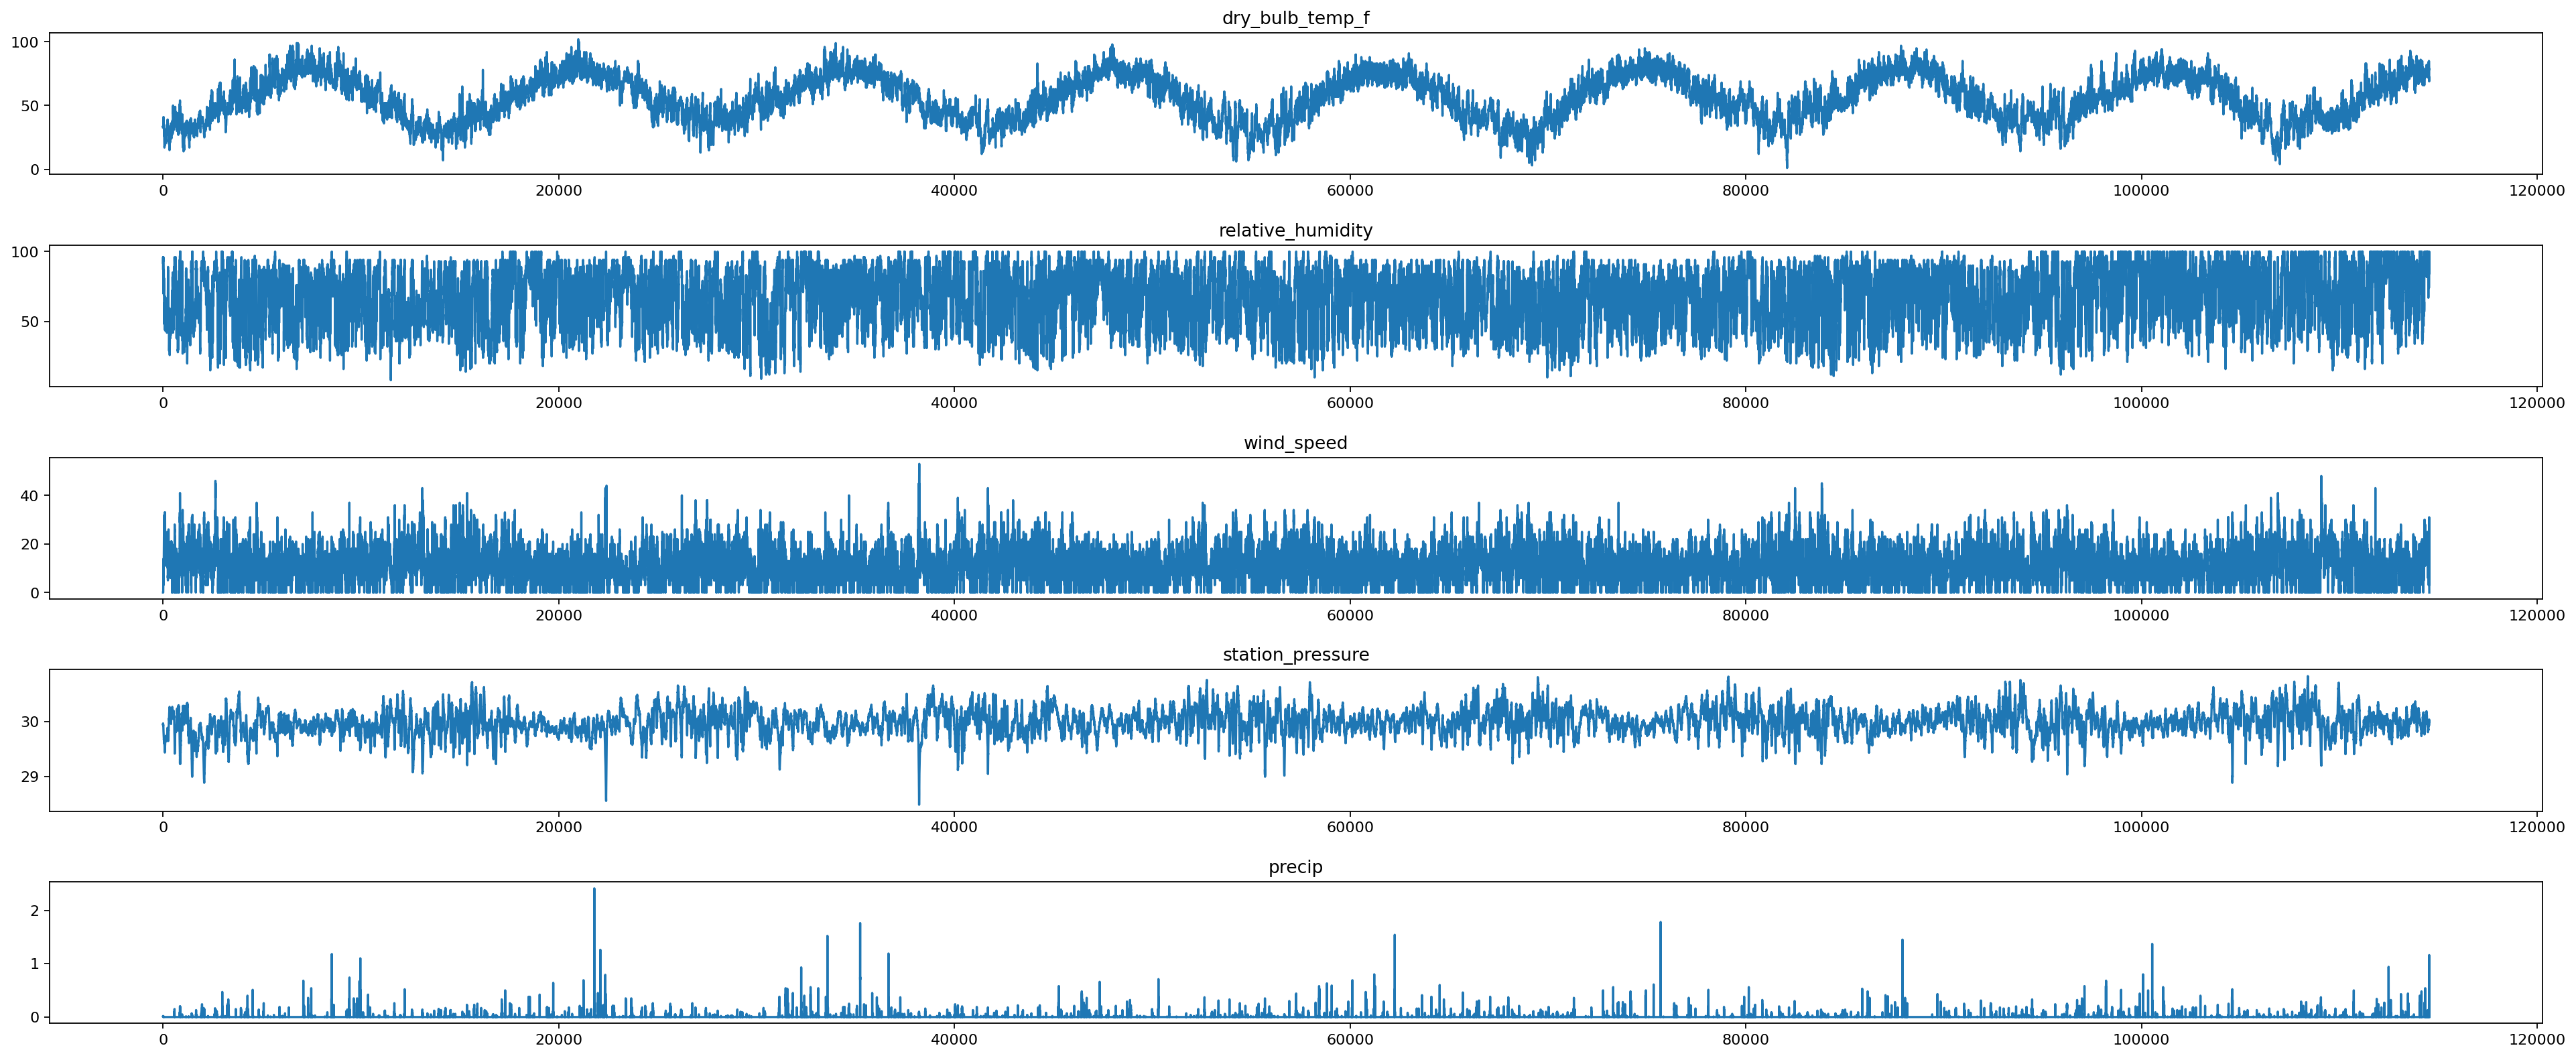

In [38]:
# Quick overview of columns
plt.figure(figsize=(30, 12))
i = 1
for col in plot_cols:
    plt.subplot(len(plot_cols), 1, i)
    plt.plot(data[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Feature Dependencies
Now we explore how the features (columns) of our data are related to each other. This helps in deciding which features to use when modelling a classifier or regresser. We ideally want independent features to be classified independently and likewise dependent features to be contributing to the same model.

We can see from the correlation plots how some features are somewhat correlated and could be used as additional data (perhaps for augmenting) when training a classifier.

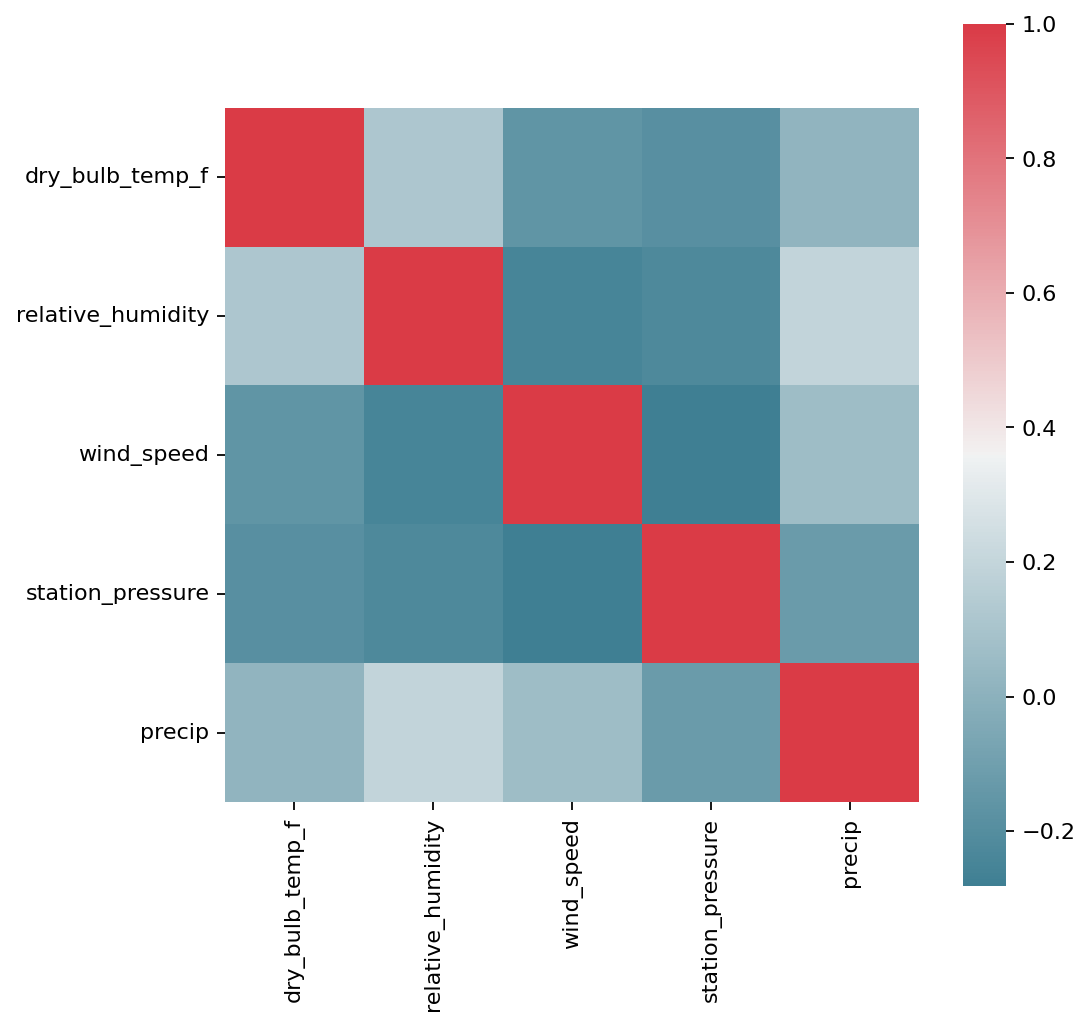

In [39]:
# Plot correlation matrix
f, ax = plt.subplots(figsize=(7, 7))
corr = data[plot_cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

Additionally we also visualize the joint distrubitions in the form of pairplots/scatter plots to see (qualitatively) the way in which these features are related in more detail over just the correlation. They are essentially 2D joint distributions in the case of off-diagonal subplots and the histogram (an approximation to the probability distribution) in case of the diagonal subplots.

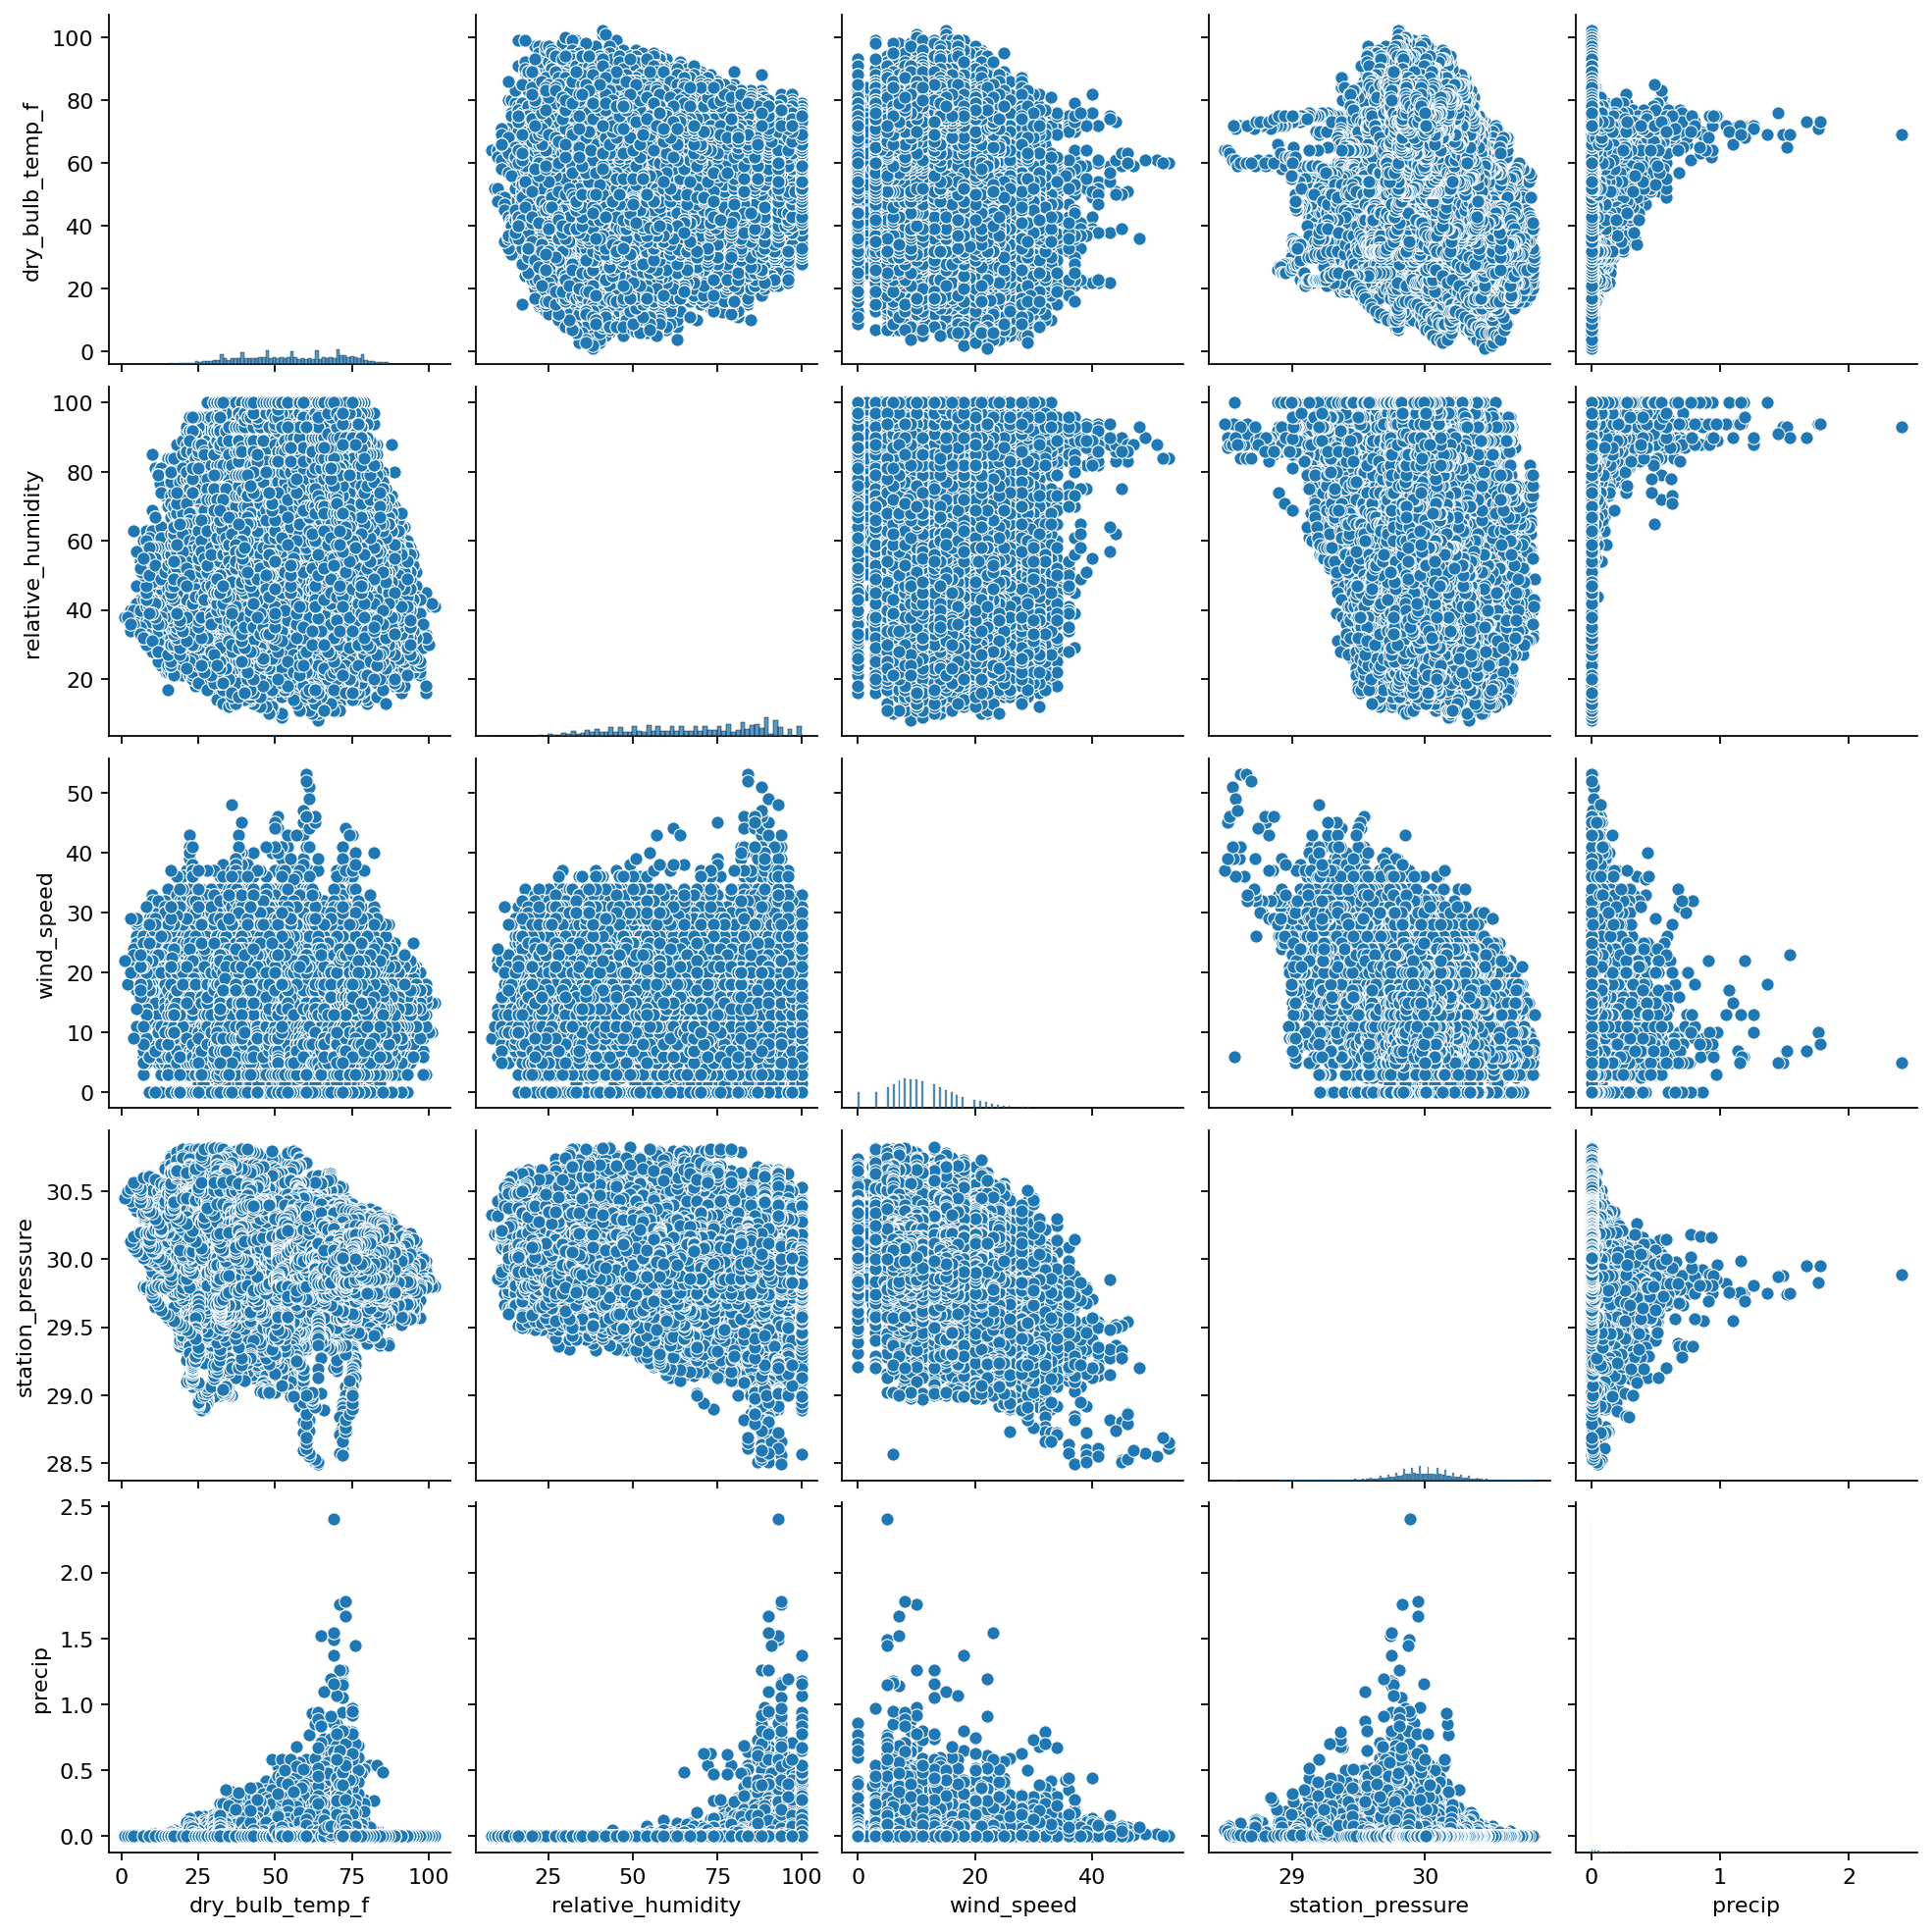

In [40]:
# Plot pairplots
sns.pairplot(data[plot_cols])

### Analyze Trends in the Data
Now that we have explored the whole dataset and the features on a high level, let us focus on one particular feature - dry_bulb_temp_f, the dry bulb temperature in degrees Fahrenheit. This is what we mean when we refer to "air temperature". This is the most common feature used in temperature prediction, and here we explore it in further detail.

We first start with plotting the data for all 9 years in monthly buckets then drill down to a single year to notice (qualitatively) the overall trend in the data. We can see from the plots that every year has roughly a sinousoidal nature to the temperature with some anomalies around 2013-2014. Upon further drilling down we see that each year's data is not the smooth sinousoid but rather a jagged and noisy one. But the overall trend still is a sinousoid.

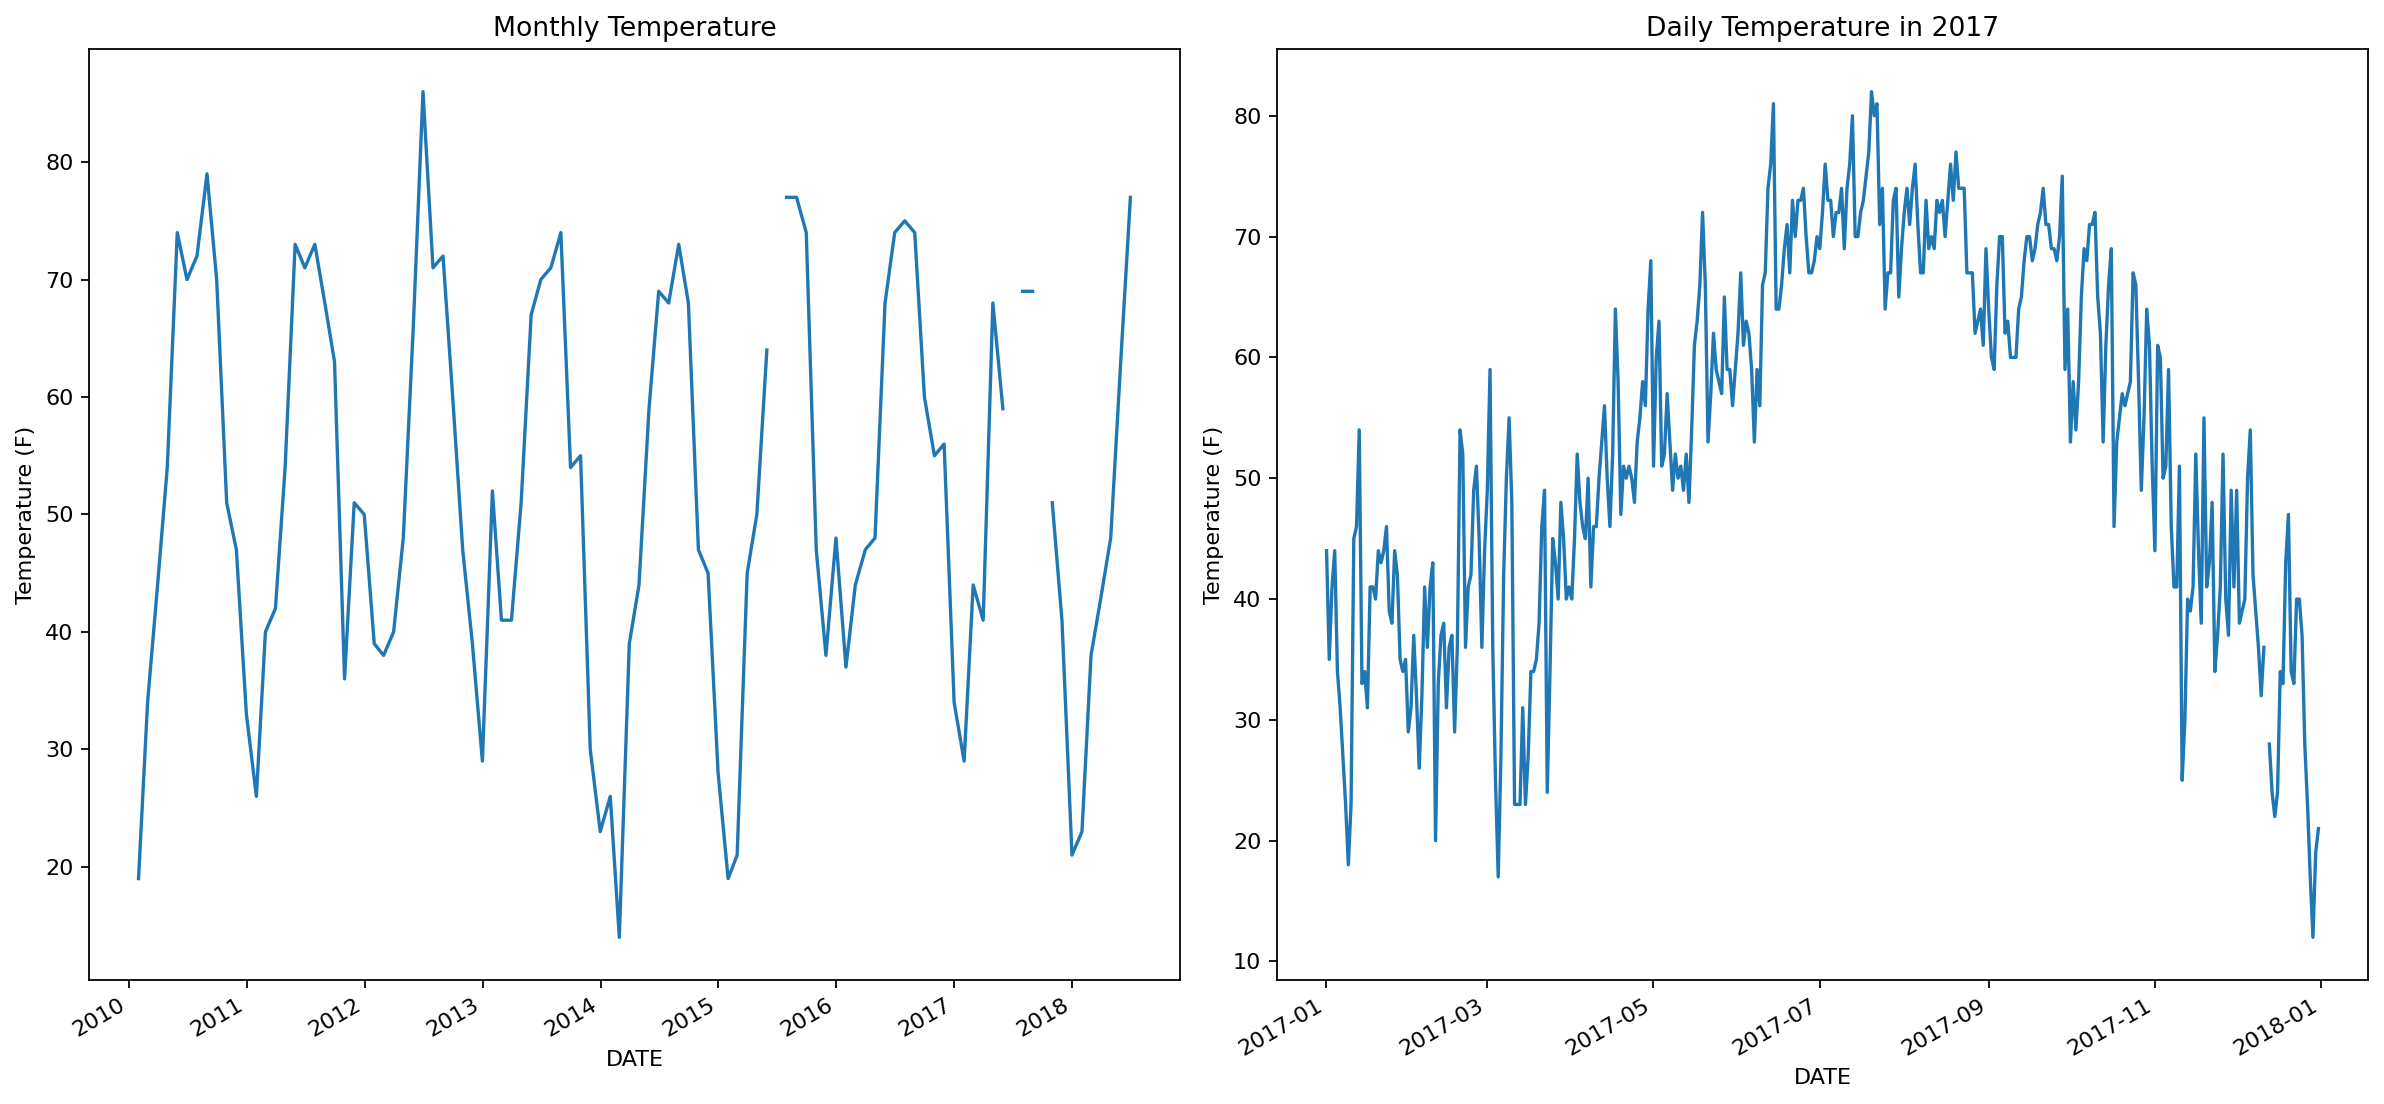

In [41]:
plt.figure(figsize=(15,7))

TEMP_COL = 'dry_bulb_temp_f'
# Plot temperature data converted to a monthly frequency 
plt.subplot(1, 2, 1)
#data = data[~data.index.duplicated(keep='first')]
data[TEMP_COL].asfreq('ME').plot()  
plt.title('Monthly Temperature')
plt.ylabel('Temperature (F)')

# Zoom in on a year and plot temperature data converted to a daily frequency 
plt.subplot(1, 2, 2)
data.loc['2017', TEMP_COL].asfreq('D').plot()
plt.title('Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

Next, we plot the change (delta) in temperature and notice that it is lowest around the middle of the year. That is expected behaviour as the gradient of the sinousoid near it's peak is zero.

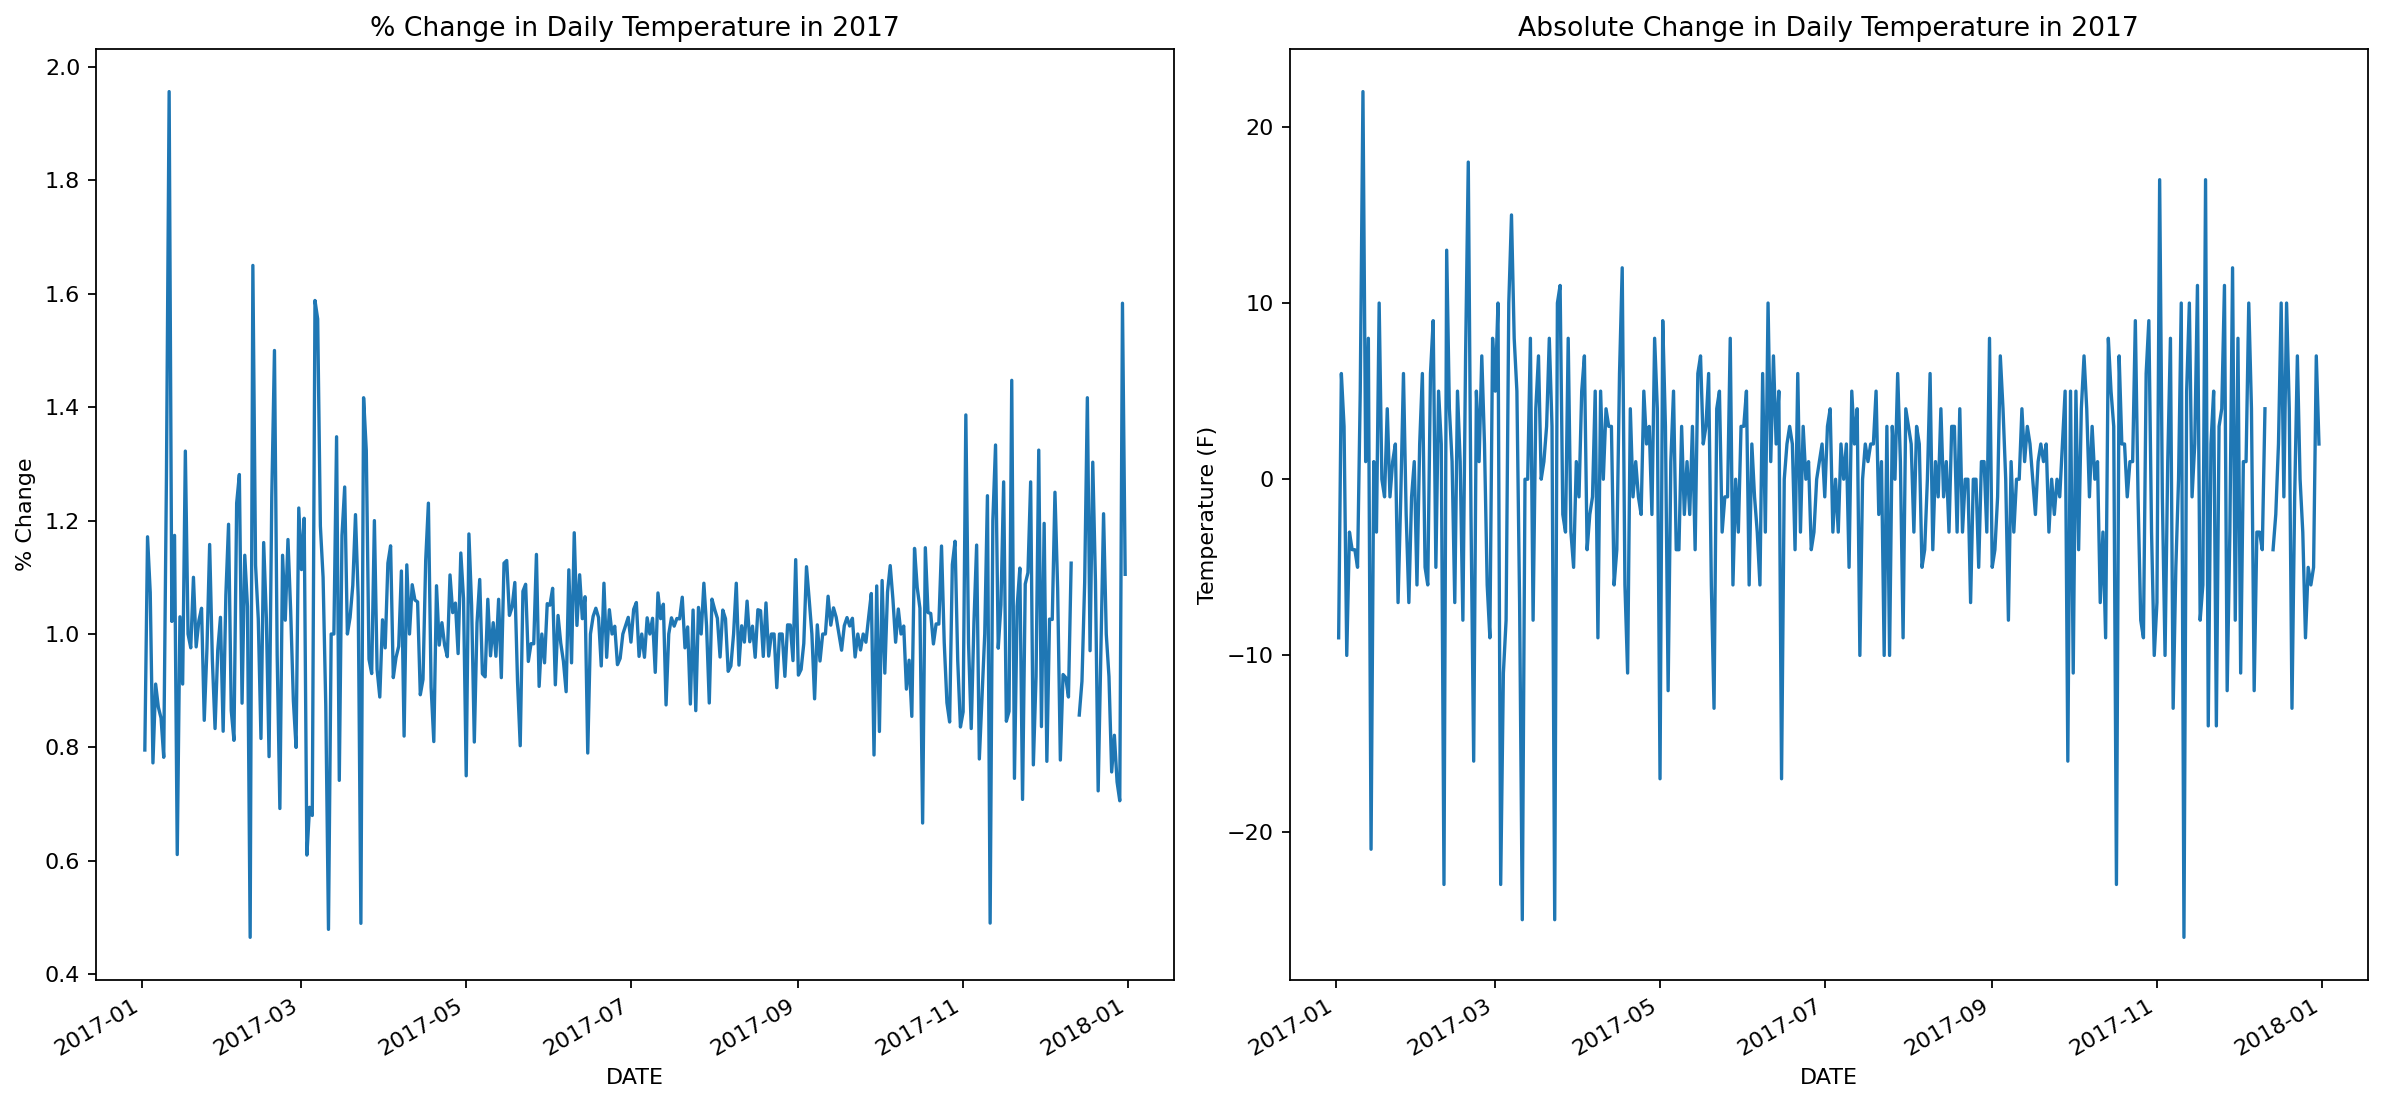

In [42]:
plt.figure(figsize=(15,7))

# Plot percent change of daily temperature in 2017
plt.subplot(1, 2, 1)
data.loc['2017', TEMP_COL].asfreq('D').div(
    data.loc['2017', TEMP_COL].asfreq('D').shift()
).plot()
plt.title('% Change in Daily Temperature in 2017')
plt.ylabel('% Change')

# Plot absolute change of temperature in 2017 with daily frequency
plt.subplot(1, 2, 2)

data.loc['2017', TEMP_COL].asfreq('D').diff().plot()

plt.title('Absolute Change in Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

Finally we apply some smoothing to the data in the form of a rolling/moving average. This is the simplest form of de-noising the data. As we can see from the plots, the average (plotted in blue) roughly traces the sinousoid and is now much smoother. This can improve the accuracy of a regression model trained to predict temperatures within a reasonable margin of error.

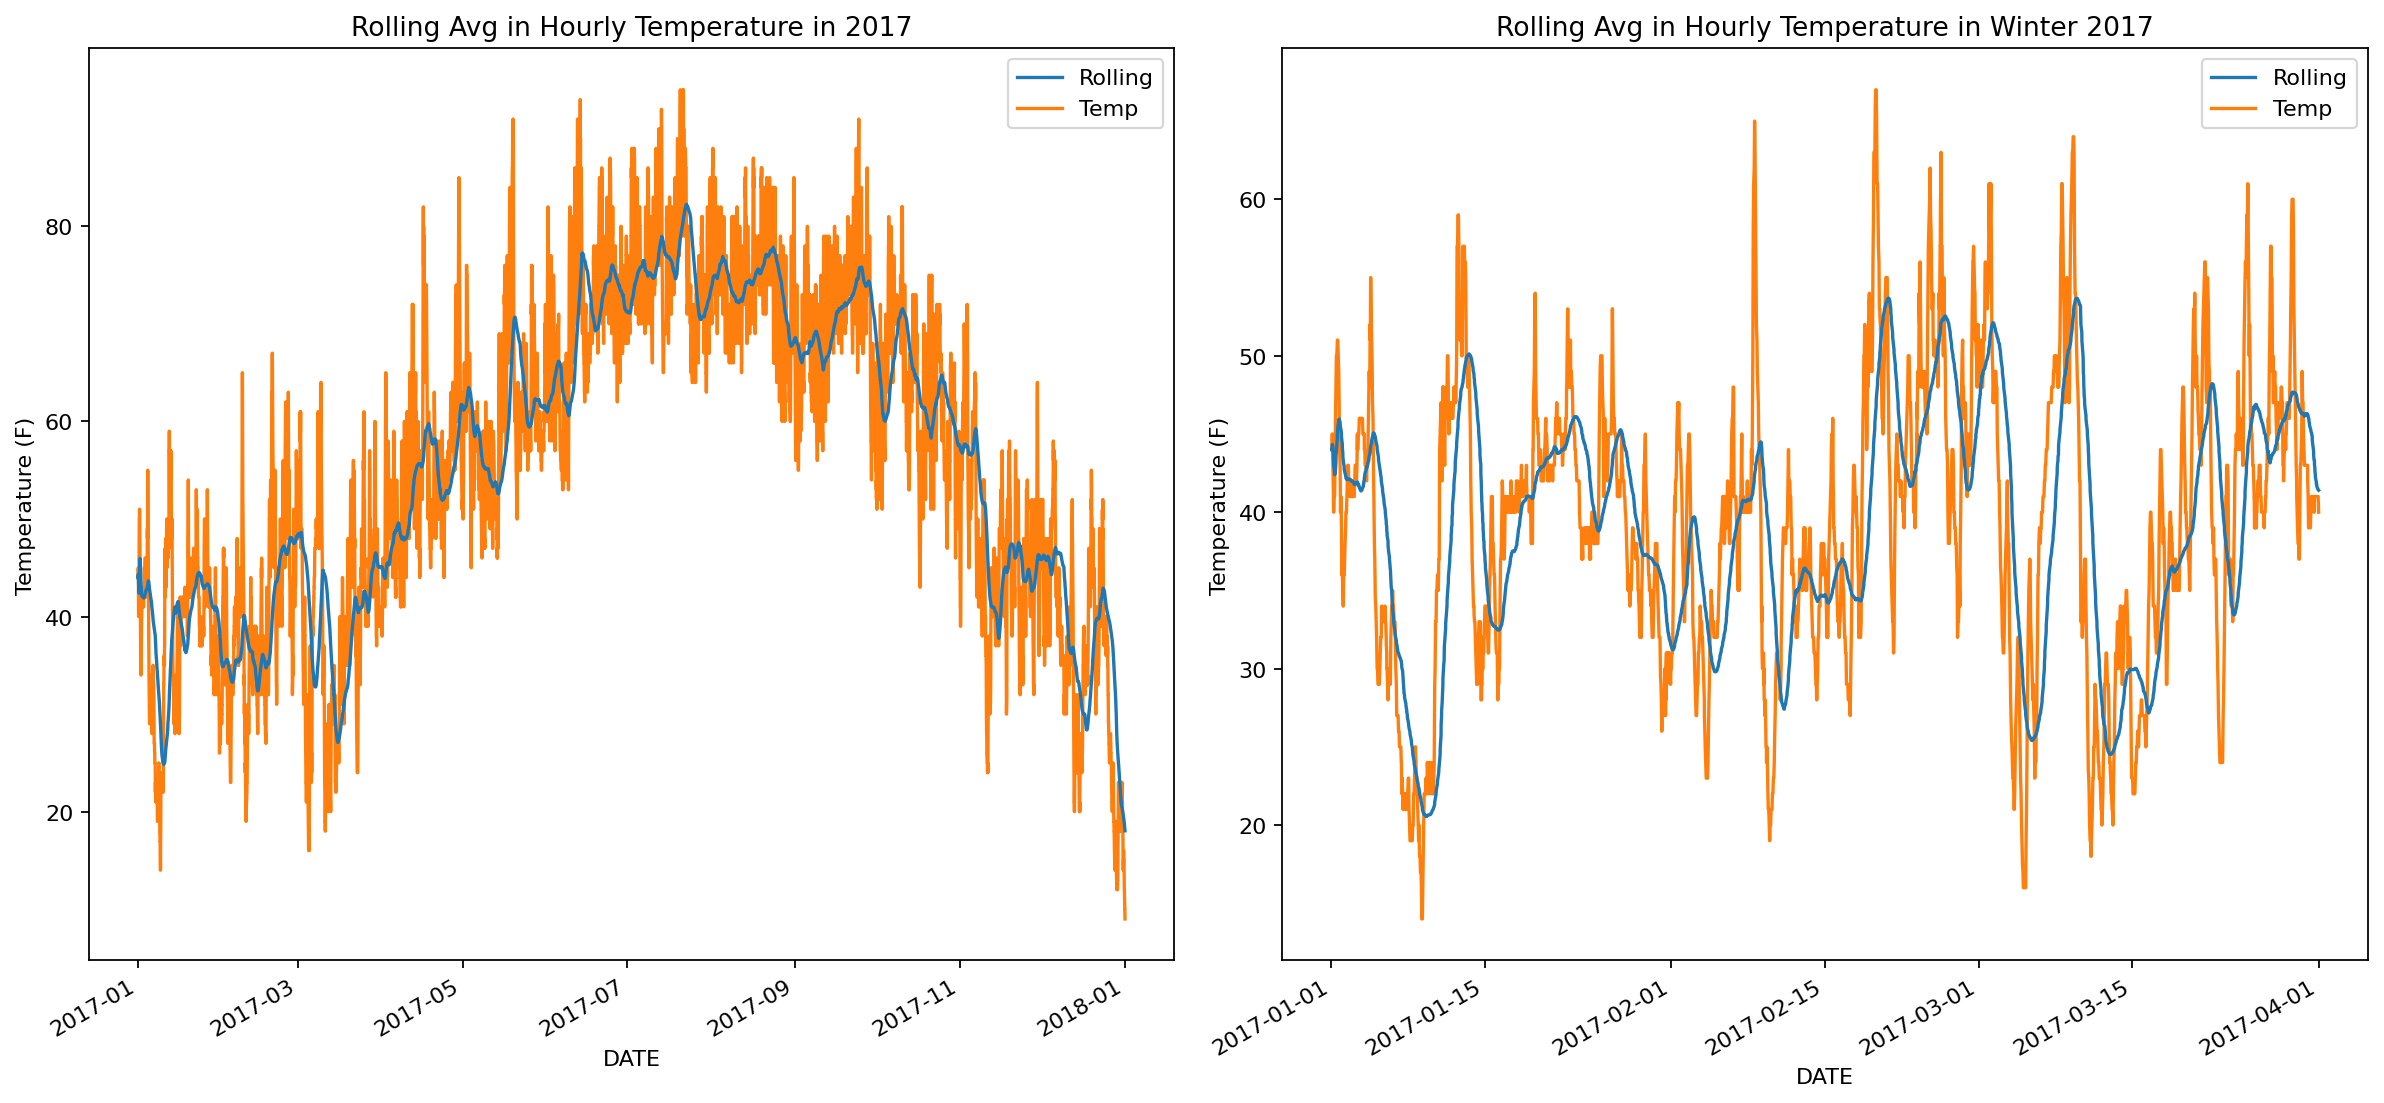

In [43]:
plt.figure(figsize=(15, 7))

# Plot rolling mean of temperature 
plt.subplot(1, 2, 1)
data.loc['2017', TEMP_COL].rolling('5D').mean().plot(zorder=2)  # 5-day rolling mean
data.loc['2017', TEMP_COL].plot(zorder=1)
plt.legend(['Rolling', 'Temp'])
plt.title('Rolling Avg in Hourly Temperature in 2017')
plt.ylabel('Temperature (F)')

# Plot rolling mean of temperature for Jan–Mar 2017
plt.subplot(1, 2, 2)
data.loc['2017-01':'2017-03', TEMP_COL].rolling('2D').mean().plot(zorder=2)  # 2-day rolling mean
data.loc['2017-01':'2017-03', TEMP_COL].plot(zorder=1)
plt.legend(['Rolling', 'Temp'])
plt.title('Rolling Avg in Hourly Temperature in Winter 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

# Part 3: Time Series Forecasting

In [44]:
%%capture
# Install required libraries
%pip install scikit-learn
%pip install statsmodels

For purposes of time-series modeling, we will restrict our analysis to a 2-year sample of the dataset to avoid overly long model-training times.

In [45]:
data.reset_index(inplace=True)
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 2: Set 'DATE' as the index
data.set_index('DATE', inplace=True)

# Step 3: Now slice using date strings
sample = data['2016-01-01':'2018-01-01']
sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26289 entries, 2016-01-01 00:51:00 to 2018-01-01 23:59:00
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   visibility               26289 non-null  float64
 1   dry_bulb_temp_f          26289 non-null  float64
 2   wet_bulb_temp_f          26289 non-null  float64
 3   dew_point_temp_f         26289 non-null  float64
 4   relative_humidity        26289 non-null  float64
 5   wind_speed               26289 non-null  float64
 6   station_pressure         26289 non-null  float64
 7   sea_level_pressure       26289 non-null  float64
 8   precip                   26289 non-null  float64
 9   altimeter_setting        26289 non-null  float64
 10  wind_direction_sin       26289 non-null  float64
 11  wind_direction_cos       26289 non-null  float64
 12  pressure_tendency_incr   26289 non-null  int64  
 13  pressure_tendency_decr   26289 non-null  

### Create Training/Validation/Test Splits
Before we attempt any time-series analysis and prediction, we should split the dataset into training, validation and test sets. We use a portion of the data for training, and a portion of future data for our validation and test sets.

If we instead trained a model on the full dataset, the model would learn to be very good at making predictions on that particular dataset, essentially just copying the answers it knows. However, when presented with data the model has not seen , it would perform poorly since it has not learned how to generalize its answers.

By training on a portion of the dataset and testing the model's performance on another portion of the dataset (which data the model has not seen in training), we try to avoid our models "over-fitting" the dataset and make them better at predicting temperatures given unseen, future data. This process of splitting the dataset and evaluating a model's performance on the validation and test sets is commonly known as cross-validation).

By default here we use 80% of the data for the training set and 10% each for validation and test sets.

In [46]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    Splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data) * (1 - test_size - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    
    return df_train, df_val, df_test


# Create data split
df_train, df_val, df_test = split_data(sample)

print('Total data size:      {} rows'.format(len(sample)))
print('Training set size:    {} rows'.format(len(df_train)))
print('Validation set size:  {} rows'.format(len(df_val)))
print('Test set size:        {} rows'.format(len(df_test)))

Total data size:      26289 rows
Training set size:    21031 rows
Validation set size:  2629 rows
Test set size:        2629 rows


### Explore Baseline Models
In this section, we'll create a few simple predictive models of temperature, using shifting and rolling averages. These will serve as a baseline against which we can compare more sophisticated models.

Using values at recent timesteps (such as the most recent timestep t-1 and second-most recent timestep t-2) to predict the current value at time t is what's known as persistence modeling, or using the last observed value to predict the next following value. These preceding timesteps are often referred to in time-series analysis as lags. So, the value at time t-1 is known as the 1st lag and the value at time t-2 is the 2nd lag.

We can also create baselines based on rolling (or moving) averages. This is a time-series constructed by averaging each lagged value up to the selected lag. For example, a 6-period (or 6-lag) rolling avearge is the average of the previous 6 hourly lags t-6 to t-1.

Our baseline models will be:

1st lag - i.e. values at t-1
2nd lag - i.e. values at t-2
6-lag rolling average
12-lag rolling average

In [47]:
%%capture
# define the column containing the data we wish to model - in this case Dry Bulb Temperature (F)
Y_COL = 'dry_bulb_temp_f'

# Use shifting and rolling averages to predict Y_COL (t)
n_in = 2
n_out = 1
features = [Y_COL]
n_features = len(features)

# create the baseline on the entire sample dataset.
# we will evaluate the prediction error on the validation set
baseline = sample[[Y_COL]].loc[:]
baseline['{} (t-1)'.format(Y_COL)] = baseline[Y_COL].shift(1)
baseline['{} (t-2)'.format(Y_COL)] = baseline[Y_COL].shift(2)
baseline['{} (6hr rollavg)'.format(Y_COL)] = baseline[Y_COL].rolling('6H').mean()
baseline['{} (12hr rollavg)'.format(Y_COL)] = baseline[Y_COL].rolling('12H').mean()
baseline.dropna(inplace=True)
baseline.head(10)

Next, we will plot data from our validation dataset to get a sense for how well these baseline models predict the next hourly temperature. Note thatd we only use a few days of data in order to make the plot easier to view.

In [48]:
# plot first 7 days of the validation set, 168 hours 
start = df_val.index[0]
end = df_val.index[167]
sliced = baseline[start:end]

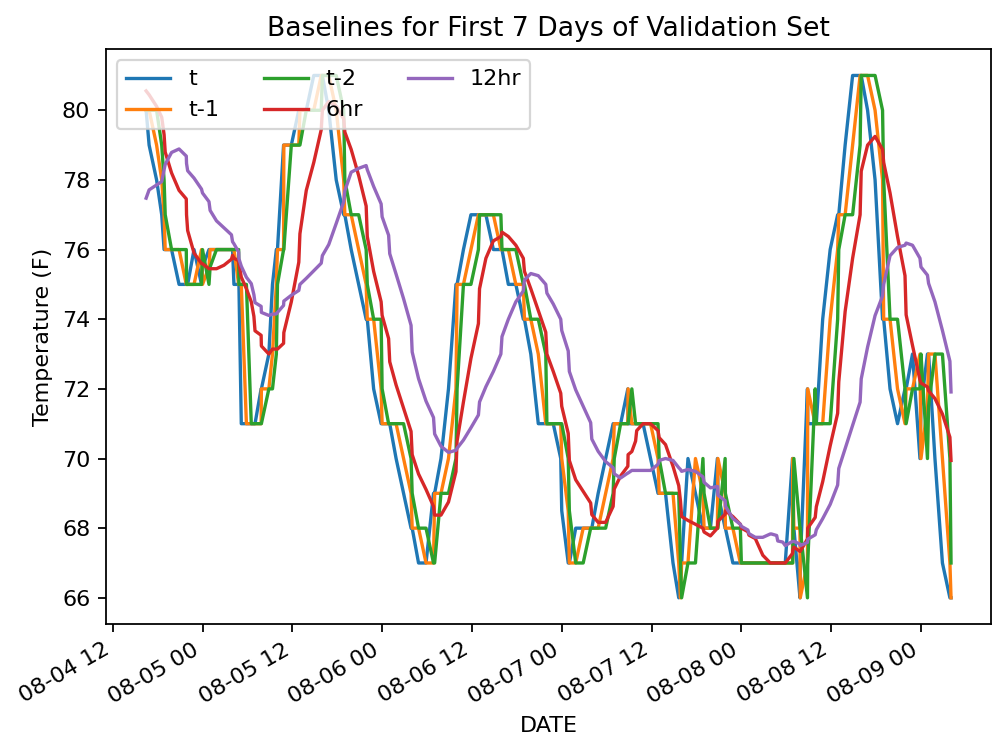

In [49]:
# Plot baseline predictions sample
cols = ['dry_bulb_temp_f', 'dry_bulb_temp_f (t-1)', 'dry_bulb_temp_f (t-2)', 'dry_bulb_temp_f (6hr rollavg)', 'dry_bulb_temp_f (12hr rollavg)']
sliced[cols].plot()

plt.legend(['t', 't-1', 't-2', '6hr', '12hr'], loc=2, ncol=3)
plt.title('Baselines for First 7 Days of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.rcParams['figure.dpi'] = 100
plt.show()

Evaluate baseline models As you can perhaps see from the graph above, the lagged baselines appear to do a better job of forecasting temperatures than the rolling average baselines.

In order to evaluate our baseline models more precisely, we need to answer the question "how well do our models predict future temperature?". In regression problems involving prediction of a numerical value, we often use a measure of the difference between our predicted value and the actual value. This is referred to as an error measure or error metric. A common measure is the Mean Squared Error (MSE):

MSE
=
1
n
n
∑
i
=
1
 
(
y
i
−
^
y
i
)
2

This is the average of the squared differences between predicted values
and actual values
.

Because the MSE is in "units squared" it can be difficult to interpet, hence the Root Mean Squared Error (RMSE) is often used:

RMSE
=



⎷
1
n
n
∑
i
=
1
 
(
y
i
−
^
y
i
)
2

This is the square root of the MSE, and is in the same units as the values
. We can compare the RMSE (and MSE) values for different models and say that the model that has the lower MSE is better at predicting temperatures, all things equal. Note that MSE and RMSE will grow large quickly if the differences between predicted and actual values are large. This may or may not be a desired quality of your error measure. In this case, it is probably a good thing, since a model that makes large mistakes in temperature prediction will be much less useful than one which makes small mistakes.

Next, we calculate the RMSE measure for each of our baseline models, on the full validation set.

In [50]:
# Calculating baseline RMSE
from sklearn.metrics import mean_squared_error

start_val = df_val.index[0]
end_val = df_val.index[-1]
baseline_val = baseline[start_val:end_val]

baseline_y = baseline_val[Y_COL]
baseline_t1 = baseline_val['dry_bulb_temp_f (t-1)']
baseline_t2 = baseline_val['dry_bulb_temp_f (t-2)']
baseline_avg6 = baseline_val['dry_bulb_temp_f (6hr rollavg)']
baseline_avg12 = baseline_val['dry_bulb_temp_f (12hr rollavg)']

rmse_t1 = round(np.sqrt(mean_squared_error(baseline_y, baseline_t1)), 2)
rmse_t2 = round(np.sqrt(mean_squared_error(baseline_y, baseline_t2)), 2)
rmse_avg6 = round(np.sqrt(mean_squared_error(baseline_y, baseline_avg6)), 2)
rmse_avg12 = round(np.sqrt(mean_squared_error(baseline_y, baseline_avg12)), 2)

print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))
print('Baseline t-2 RMSE:            {0:.3f}'.format(rmse_t2))
print('Baseline 6hr rollavg RMSE:    {0:.3f}'.format(rmse_avg6))
print('Baseline 12hr rollavg RMSE:   {0:.3f}'.format(rmse_avg12))

Baseline t-1 RMSE:            1.380
Baseline t-2 RMSE:            2.210
Baseline 6hr rollavg RMSE:    3.020
Baseline 12hr rollavg RMSE:   4.760


### Train Statistical Time-series Analysis Models
In the previous section, we saw that a simple lag-1 baseline model performed reasonably well at forecasting temperature for the next hourly time step. This is perhaps not too surprising, given what we know about hourly temperatures. Generally, the temperature in a given hour will be quite closely related to the temperature in the previous hour. This phenomenon is very common in time-series analysis and is known as autocorrelation - that is, the time series is correlated with previous values of itself. More precisely, the values at time t are correlated with lagged values (which could be t-1, t-2 and so on).

Another thing we saw previously is the concept of moving averages. In this case the moving-average baseline was not that good at prediction. However it is common in many time-series for a moving average to capture some of the underlying structure and be useful for prediction.

In order to make our model better at predicting temperature, ideally we would want to take these aspects into account. Fortunately, the statistical community has a long history of analyzing time series and has created many different forecasting models.

Here, we will explore one called SARIMAX - the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model.

This sounds like a very complex name, but if we look at the components of the name, we see that it includes autocorrelation (this is what auto regressive means) and moving averages, which are the components mentioned above.

The SARIMAX model also allows including a seasonal model component as well as handling exogenous variables, which are external to the time-series value itself. For example, for temperature prediction we may wish to take into account not just previous temperature values, but perhaps other weather features which may have an effect on temperature (such as humidity, rainfall, wind, and so on).

For the purposes of this notebook, we will not explore modeling of seasonal components or exogenous variables.

If we drop the "S" and "X" from the model, we are left with an ARIMA model (Auto-regressive Integrated Moving Average). This is a very commonly used model for time-series analysis and we will use it in this notebook by only specifying the relevant model components of the full SARIMAX model.

### Replicating a baseline model
As a starting point, we will see how we can use SARIMAX to create a simple model that in fact replicates one of the baselines we created previously. Auto-regression, as we have seen, means using values from preceding time periods to predict the current value. Recall that one of our baseline models was the 1st lag or t-1 model. In time-series analysis this is referred to as an AR(1) model, meaning an Auto-Regressive model for lag 1.

Technically, the AR(1) model is not exactly the same as our baseline model. A statistical time series model like SARIMAX learns a set of weights to apply to each component of the model. These weights are set so as to best fit the dataset. We can think of our baseline as setting the weight for the t-1 lag to be exactly 1. In practice, our time-series model will not have a weight of exactly 1 (though it will likely be very close to that), hence the predictions will be slightly different.

Now, lets fit our model to the dataset. First, we will set up the model inputs by taking the temperature column of our dataframe. We do this for training and validation sets.

In [51]:
X_train = df_train[Y_COL]
X_val = df_val[Y_COL]
X_both = np.hstack((X_train, X_val))

Here we created a variable called X_both to cover both the training and validation data. This is required later when we forecast values for our SARIMAX model, in order to give the model access to all the datapoints for which it must create forecasts. Note that the forecasts themselves will only be based on the model weights learned from the training data (this is important for over-fitting as we have seen above)!

The SARIMAX model takes an argument called order: this specifies the components of the model and itself has 3 parts: (p, d, q). p denotes the lags for the AR model and q denotes the lags for the MA model. We will not cover the d parameter here. Taken together this specifies the parameters of the ARIMA model portion of SARIMAX.

To create an AR(1) model, we set the order to be (1, 0, 0). This sets up the AR model to be a lag 1 model. Then, we fit our model on the training data and inspect a summary of the trained model.

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 0, 0)
model_ar1 = SARIMAX(X_train, order=order)
results_ar1 = model_ar1.fit()
results_ar1.summary()

c:\Users\aristide.houngninou\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aristide.houngninou\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        dry_bulb_temp_f   No. Observations:                21031
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -37045.418
Date:                Thu, 13 Nov 2025   AIC                          74094.835
Time:                        11:54:03   BIC                          74110.743
Sample:                             0   HQIC                         74100.027
                              - 21031                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   6412.745      0.000       0.999       1.000
sigma2         1.9832      0.011    187.882      0.000       1.962       2.004
===================================================================================
Ljung-Box (L1) (Q):                 830.56   Jarque-Bera (JB):             19797.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step). There's quite a lot of information printed out in the model summary above. Much of it is related to the statistical properties of our model.

The most important thing for now is to look at the second table, where we can see a coef value of 0.9996 for the weight ar.L1. This tells us the model has set a weight for the 1st lag component of the AR model to be 0.9996. This is almost 1 and hence we should expect the prediction results to indeed be close to our t-1 baseline.

Let's create our model forecast on the validation dataset. We will then plot a few data points like we did with our baseline models (using 7 days of validation data) and compute the RMSE value based on the full validation set.

In [55]:
full_data_ar1 = SARIMAX(X_both, order=order)
model_forecast_ar1 = full_data_ar1.filter(results_ar1.params)

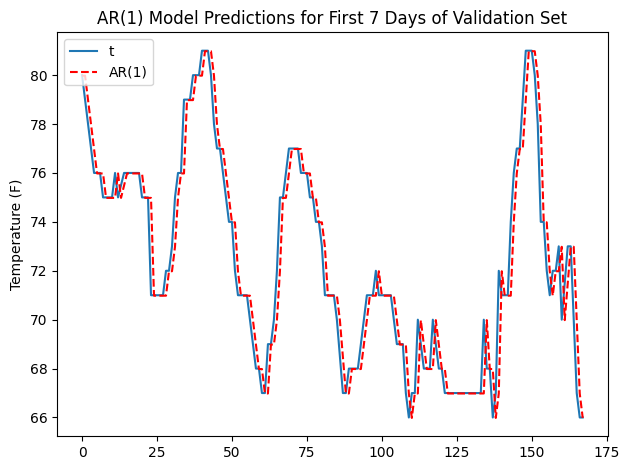

In [56]:
start = len(X_train)
end = len(X_both)
forecast_ar1 = model_forecast_ar1.predict(start=start, end=end - 1, dynamic=False)

# plot actual vs predicted values for the same 7-day window for easier viewing
plt.plot(sliced[Y_COL].values)
plt.plot(forecast_ar1[:168], color='r', linestyle='--')
plt.legend(['t', 'AR(1)'], loc=2)
plt.title('AR(1) Model Predictions for First 7 Days of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

We can see that the plot looks almost identical to the plot above, for the t and t-1 baseline values.

Next, we compute the RMSE values.

In [57]:
# compute print RMSE values
rmse_ar1 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar1))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(1) RMSE:                   1.379
Baseline t-1 RMSE:            1.380


We can see that the RMSE values for the validation set also almost identical.

## Create a more complex model
One of our baseline models was a lag 2 model, i.e. t-2. We saw that it performed a lot worse than the t-1 baseline. Intuitively, this makes sense, since we are throwing away a lot of information about the most recent lag t-1. However, the t-2 lag still provides some useful information. In fact, for temperature prediction it's likely that the last few hours can provide some value.

Fortunately, our ARIMA model framework provides an easy way to incorporate further lag information. We can construct a model that includes both the t-1 and t-2 lags. This is an AR(2) model (meaning an auto-regressive model up to lag 2). We can specify this with the model order parameter p=2.

In [58]:
%%capture
order = (2, 0, 0)
model_ar2 = SARIMAX(X_train, order=order)
results_ar2 = model_ar2.fit()
results_ar2.summary()

### Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

This time, the results table indicates a weight for variable ar.L1 and ar.L2. Note the values are now quite different from 1 (or 0.5 say, for a simple equally-weighted model). Next, we compute the RMSE on the validation set.

In [59]:
full_data_ar2 = SARIMAX(X_both, order=order)
model_forecast_ar2 = full_data_ar2.filter(results_ar2.params)

start = len(X_train)
end = len(X_both)
forecast_ar2 = model_forecast_ar2.predict(start=start, end=end - 1, dynamic=False)

# compute print RMSE values
rmse_ar2 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar2))
print('AR(2) RMSE:                   {0:.3f}'.format(rmse_ar2))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(2) RMSE:                   1.328
AR(1) RMSE:                   1.379
Baseline t-1 RMSE:            1.380


We've improved the RMSE value by including information from the first two lags.

In fact, you will see that if you continue to increase the p parameter value, the RMSE will continue to decrease, indicating that a few recent lags provide useful information to our model.

### Incorporate moving averages
Finally, what if we also include moving average information in our model? The ARIMA framework makes this easy to do, by setting the order parameter q. A value of q=1 specifies a MA(1) model (including the first lag t-1), while q=6 would include all the lags from t-1 to t-6.

Note that the moving average model component is a little different from the simple moving or rolling averages computed in the baseline models. The definition of the MA model is rather technical, but conceptually you can think of it as using a form of weighted moving average (compared to our baseline which would be a simple, unweighted average).

Let's add an MA(1) component to our AR(2) model.

In [60]:
%%capture
order = (2, 0, 1)
model_ar2ma1 = SARIMAX(X_train, order=order)
results_ar2ma1 = model_ar2ma1.fit()
results_ar2ma1.summary()

### Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

We see the results table shows an additional weight value for ma.L1, our MA(1) component. Next, we compare the RMSE to the other models and finally plot all the model forecasts together - note we use a much smaller 48-hour window to make the plot readable for illustrative purposes.

In [61]:
full_data_ar2ma1 = SARIMAX(X_both, order=order)
model_forecast_ar2ma1 = full_data_ar2ma1.filter(results_ar2ma1.params)

start = len(X_train)
end = len(X_both)
forecast_ar2ma1 = model_forecast_ar2ma1.predict(start=start, end=end - 1, dynamic=False)

# compute print RMSE values
rmse_ar2ma1 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar2ma1))
print('AR(2) MA(1) RMSE:             {0:.3f}'.format(rmse_ar2ma1))
print('AR(2) RMSE:                   {0:.3f}'.format(rmse_ar2))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(2) MA(1) RMSE:             1.291
AR(2) RMSE:                   1.328
AR(1) RMSE:                   1.379
Baseline t-1 RMSE:            1.380


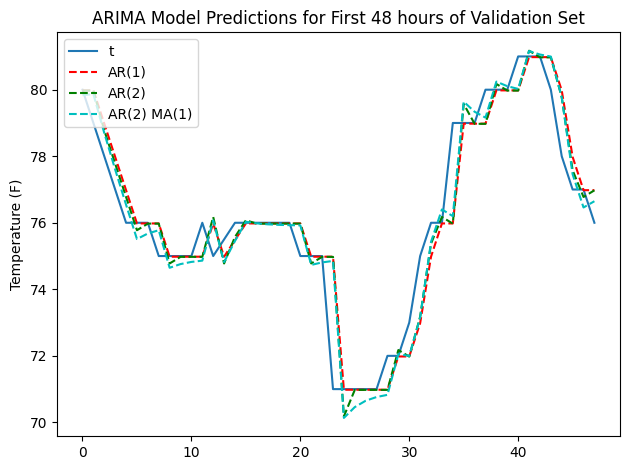

In [62]:
# plot actual vs predicted values for a smaller 2-day window for easier viewing
hrs = 48
plt.plot(sliced[Y_COL][:hrs].values)
plt.plot(forecast_ar1[:hrs], color='r', linestyle='--')
plt.plot(forecast_ar2[:hrs], color='g', linestyle='--')
plt.plot(forecast_ar2ma1[:hrs], color='c', linestyle='--')
plt.legend(['t', 'AR(1)', 'AR(2)', 'AR(2) MA(1)'], loc=2, ncol=1)
plt.title('ARIMA Model Predictions for First 48 hours of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

We've again managed to reduce the RMSE value for our model, indicating that adding the MA(1) component has improved our forecast!

Congratulations! You've applied the basics of time-series analysis for forecasting hourly temperatures. See if you can further improve the RMSE values by exploring the different values for the model parameters p, q and even d!